# Evolution du bruit médian en France depuis le début de la pandémie

> Ce Notebook présente lévolution du bruit médian en France depuis lde début de l'épidémie

---
## Importation des modules

In [1]:
%matplotlib inline

import datetime
import os
from glob import glob

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import tqdm.notebook as tqdm
import warnings
from scipy import optimize
from scipy.signal import hilbert

from obspy import UTCDateTime, read
from obspy.clients.fdsn import Client
from obspy.clients.fdsn.client import FDSNNoDataException
from obspy.signal import PPSD

%load_ext autoreload
%autoreload 2
from seismic_noise import *
import seismosocialdistancing

---
## Paramètre initiaux

In [2]:
PPSD_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/PPSD"
DRMS_FOLDER  = "/media/flavien/Flavien USB/Stages/noise_data/DRMS"
MSEED_FOLDER = "/media/flavien/Flavien USB/Stages/noise_data/MSEED"
DATA_FOLDER  = "DATA"
freqs = [(0.01, 0.03), (0.1, 0.25), (0.3, 1), (1, 3), (5, 15), (20, 50)] # Bandes de fréquences à étudier
freq = "5.0-15.0"

tStart = "2020-01-01"
tEnd   = "2021-08-01"

# list_stations = ["FR.STR.00.HHZ", "FR.CURIE.00.HHZ", "FR.BRGF.00.HHZ"]
list_stations = np.loadtxt(DATA_FOLDER + "/st_metadata/stations_fr.txt", dtype=str)

In [3]:
tags = {
    "2020-03-17": "Lockdown 1",
    "2020-05-11": "End lockdown",
    "2020-10-30": "Lockdown 2",
    "2020-12-15": "End lockdown + Curfew 20h",
    "2020-12-25": "Christmas",
    "2021-01-01": "New Year",
    "2021-01-16": "Curfew 18h",
    "2021-03-20": "Curfew 19h",
    "2021-04-03": "Lockdown 3",
    "2021-05-03": "End of certificate",
    "2021-05-19": "Curfew 21h + Shops open",
    "2021-06-09": "Curfew 23h + Restaurants open",
    "2021-06-30": "End Curfew"
}
dates_tags = pd.to_datetime(([key for key in tags.keys()]))
desc_tags = [(value) for value in tags.values()]

---
## Médiane à toutes les stations

#### Calcul de la médiane pour chaque station

On calcul les PPSDs sur l'ensemble des périodes d'un mois (1 mois pendant le confinement, 1 mois hors confinement). Toutes les données sont stockées dans le dictionnaire `ppsds`.

In [4]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [6]:
med_values = []
st_list = []

for j, st_str in tqdm.tqdm(enumerate(list_stations)):
    # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

    ### Calcul du déplacement RMS de la station
    try:
        dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
        dataframe.index=pd.to_datetime(dataframe.index)
        dRMS = dataframe
    except:
        continue
        
    st_list = np.append(st_list, st_str)    
        
    ### On garde les données dans la période temporelle qui nous intéresse
    mask_time = (dataframe.index > tStart) & (dataframe.index <= tEnd)
    dRMS = dRMS.loc[mask_time]
    
    ### Récupération du bruit
    dRMS_med = dRMS[freq].between_time("6:00", "16:00").resample("1D").median()
    dRMS_med = dfDates.join(dRMS_med, how='outer')
    

    ### Mise en graphique
    color = "#353535"
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.tick_params(direction="in", which="both", top=True, right=True)
    ax.set_title("Frequency band : {}Hz | {}".format(freq, st_str))
    ax.plot(dRMS_med, color=color, lw=2, zorder=3)
    plt.ylim(-1*np.nanquantile(dRMS_med, 0.01), 1.5*np.nanquantile(dRMS_med, 0.99))
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_xlabel("Year 2020")
    ax.set_ylabel("Median displacement [m]")

    box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("5 days")
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
        ax.text(t_text, -0.8*np.nanquantile(dRMS_med, 0.01), desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1

    plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
    plt.tight_layout()
    folder = "RESULTS/FR/{}/{}Hz".format(st_str, freq)
    if not os.path.exists(folder): os.makedirs(folder)
    plt.savefig("{}/ts_day.png".format(folder), dpi=150)
    # plt.show()
    plt.close()
    plt.clf()

    ### Normalisation du bruit
    dRMS_med = dRMS_med[freq].tolist()
    # norm = np.nanmedian(dRMS_med)
    # dRMS_med = dRMS_med/norm
    med_values.append(dRMS_med)

150it [01:43,  1.44it/s]


<Figure size 432x288 with 0 Axes>

In [6]:
print("Dimensions de la matrice :", np.shape(med_values))

Dimensions de la matrice : (142, 578)


In [7]:
# dRMS_array = med_values

# np.save('sandbaox/dates', dates)
# np.save('sandbox/st_list', st_list)
# np.save('sandbox/dRMS_array', dRMS_array)

#### Calcul de la médiane de toutes les stations

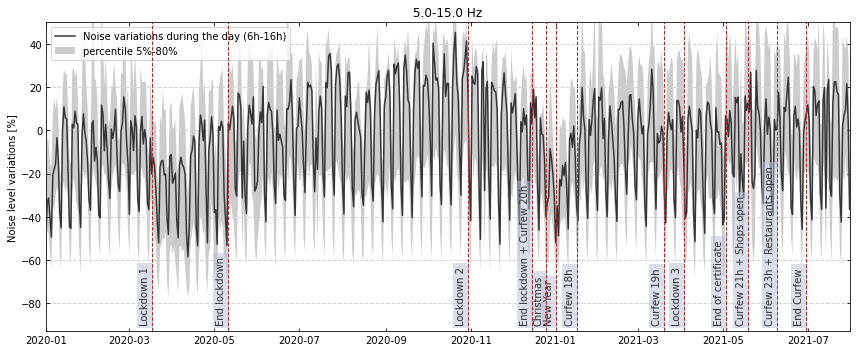

In [8]:
noise_fr = np.zeros(nDays)


for i in range(nDays):

    sublist = list()

    for j in range(np.shape(med_values)[0]):
        sublist = np.append(sublist, med_values[j][i])

    noise_fr[i] = np.nanmedian(sublist)


norm_period = ["2020-01-15", "2020-03-10"]
t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
noise_med = np.nanmedian(noise_fr)
noise_fr = (noise_fr - noise_med)/noise_med*100

color = "#353535"
fig, ax = plt.subplots(figsize=(12, 5))
ax.tick_params(direction="in", which="both", top=True, right=True)
# ax.set_title("Frequency band : {}Hz".format(freq))
ax.plot(dates, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations during the day (6h-16h)")
plt.ylim(3.5 * np.quantile(noise_fr, 0.05), 5 * np.quantile(noise_fr, 0.95))
ax.set_xlim([dates[0], dates[-1]])
# ax.set_xlabel("Year 2020")
ax.set_ylabel("Noise level variations [%]")

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("5 days")
    ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
    ax.text(t_text, -90, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1

med_var = np.zeros(np.shape(med_values))

for i in range(np.shape(med_var)[0]):
    sub_list = med_values[i][:]    
    med_var[i][:] = (sub_list - np.nanmedian(sub_list))/np.nanmedian(sub_list) * 100
    
    
perc_i = list()  # 5%
perc_f = list()  # 80%

for ii in range(np.shape(med_var)[1]):
    sublist = list()
    for i in range(np.shape(med_var)[0]):
        sublist = np.append(sublist, med_var[i][ii])

    perc_i = np.append(perc_i, np.nanquantile(sublist, 0.05))
    perc_f = np.append(perc_f, np.nanquantile(sublist, 0.8))
    
plt.fill_between(dates, perc_i, perc_f,alpha=.25, label="percentile 5%-80%", color=color, lw=0)    
plt.grid(axis="y", color="#D5D5D5", linestyle='--', linewidth=1)
plt.ylim(-93, 50)
plt.legend(loc=2)
plt.title("{} Hz".format(freq))
plt.tight_layout()
folder = "RESULTS/FR/all_stations/{}Hz".format(freq)
if not os.path.exists(folder): os.makedirs(folder)
plt.savefig("{}/ts_day.png".format(folder), dpi=150)
plt.show()

In [82]:
def enveloppe(x, f):
    lmin = (np.diff(np.sign(np.diff(f))) > 0).nonzero()[0] + 1 
    lmax = (np.diff(np.sign(np.diff(f))) < 0).nonzero()[0] + 1 

    idx_down = lmin[[i+np.argmin(f[lmin[i:i+1]]) for i in range(0,len(lmin), 1)]]
    idx_up = lmax[[i+np.argmax(f[lmax[i:i+1]]) for i in range(0,len(lmax), 1)]]
    
    env_down = np.interp(x, x[idx_down], f[idx_down])
    env_up = np.interp(x, x[idx_up], f[idx_up])
    
    return env_down, env_up

In [83]:
env_up_matrix = np.zeros(np.shape(med_var))
env_down_matrix = np.zeros(np.shape(med_var))

for i in range(np.shape(med_var)[0]):
    sub_list = med_var[i][:]
    env_down, env_up = enveloppe(dates, sub_list)
    env_up_matrix[i][:] = env_up
    env_down_matrix[i][:] = env_down

<ipython-input-166-3c4466110700>:58: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if signal_choice == "env_down": plt.pcolormesh(dates, [".", ""], [enveloppe(dates, noise_fr)[0], enveloppe(dates, noise_fr)[0]])
<ipython-input-166-3c4466110700>:68: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  if signal_choice == "env_down": plt.pcolormesh(dates, st_list, env_down_matrix)


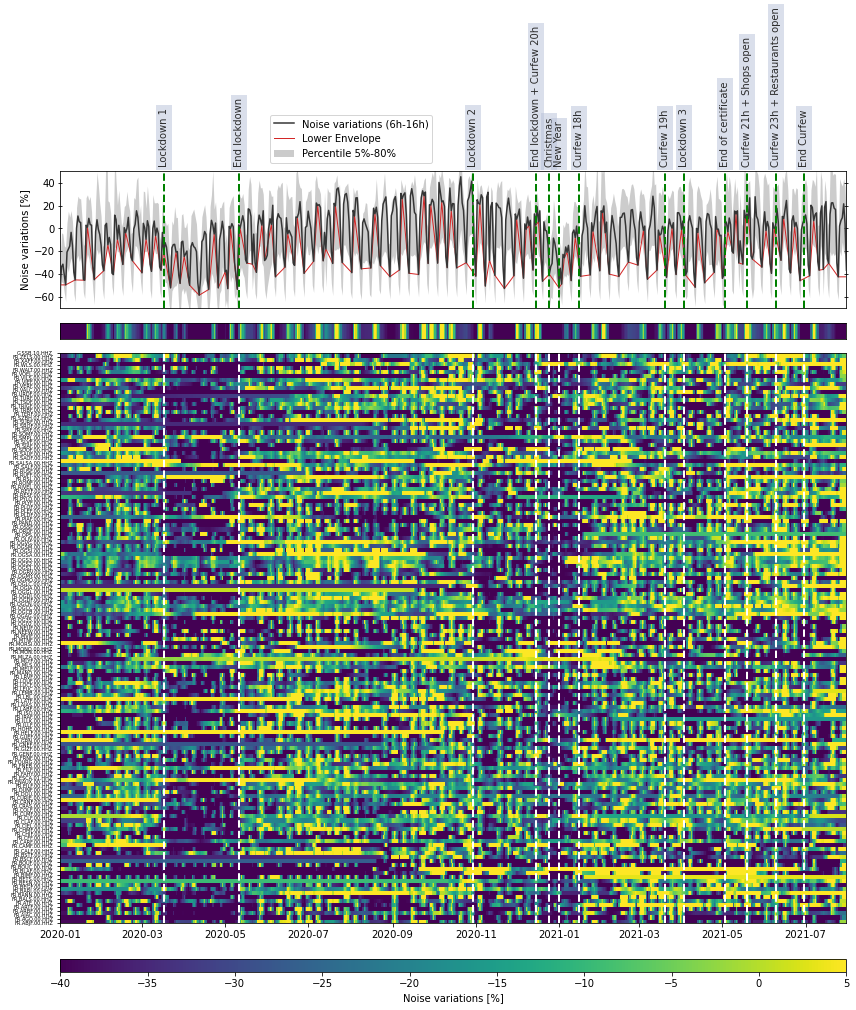

In [166]:
# Signal à afficher
signal_choice = "all" # "all", "env_up", "env_down"

for signal_choice in ["all", "env_up", "env_down"]:

    if signal_choice == "all":
        filename_suffix = ""
        cbar_lim = (-45, 45)

    if signal_choice == "env_up":
        filename_suffix = "_envUP"
        cbar_lim = (-10, 55)

    if signal_choice == "env_down":
        filename_suffix = "_envDOWN"
        cbar_lim = (-40, 5)



    fig = plt.figure(figsize=(12, 15))
    grid = plt.GridSpec(30, 1)

    box_txt = dict(boxstyle="square",
                   facecolor='#B7C0D8',
                   edgecolor='none',
                   alpha=0.5)

    ### MEDIANE
    plt.subplot(grid[:5])
    plt.tick_params(direction="inout", which="both", top=True, right=True)
    plt.ylim(3.5 * np.quantile(noise_fr, 0.05), 5 * np.quantile(noise_fr, 0.95))
    plt.xlim([dates[0], dates[-1]])
    plt.ylabel("Noise variations [%]")
    plt.plot(dates, noise_fr, color=color, lw=1.5, zorder=3, label="Noise variations (6h-16h)")
    if signal_choice == "env_up":
        plt.plot(dates, enveloppe(dates, noise_fr)[1], color="#D32727", label="Upper Envelope", lw=1)
    if signal_choice == "env_down":
        plt.plot(dates, enveloppe(dates, noise_fr)[0], color="#D32727", label="Lower Envelope", lw=1)
    plt.fill_between(dates, perc_i, perc_f,alpha=.25, label="Percentile 5%-80%", color=color, lw=0)    
    plt.ylim(-70, 50)
    plt.legend(loc=2, bbox_to_anchor=(0.26, 1.45))
    plt.xticks([])

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("0 days")
        plt.axvline(t_search, ls="--", lw=2, color="green", zorder=10)   # Confinement 1
        plt.text(t_text, 54, desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1


    ### MEDIANE COLORMESH
    plt.subplot(grid[5])
    plt.tick_params(direction="inout", which="both", top=True, right=True)
    if signal_choice == "all":      plt.pcolormesh(dates, [".", ""], [noise_fr, noise_fr])
    if signal_choice == "env_up":   plt.pcolormesh(dates, [".", ""], [enveloppe(dates, noise_fr)[1], enveloppe(dates, noise_fr)[1]])
    if signal_choice == "env_down": plt.pcolormesh(dates, [".", ""], [enveloppe(dates, noise_fr)[0], enveloppe(dates, noise_fr)[0]])
    plt.yticks([])
    plt.xticks([])
    plt.clim(cbar_lim)


    ### DETAILS
    plt.subplot(grid[6:])
    if signal_choice == "all":      plt.pcolormesh(dates, st_list, med_var)
    if signal_choice == "env_up":   plt.pcolormesh(dates, st_list, env_up_matrix)
    if signal_choice == "env_down": plt.pcolormesh(dates, st_list, env_down_matrix)
    plt.tick_params(axis='y', labelsize=5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("0 days")
        plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1

    plt.clim(cbar_lim)
    plt.colorbar(orientation="horizontal", label='Noise variations [%]', pad=0.05, shrink=1, aspect=60)
    fig.tight_layout()

    folder = "RESULTS/FR/all_stations/{}Hz".format(freq)
    if not os.path.exists(folder): os.makedirs(folder)
    plt.savefig("{}/ts_day_details{}.png".format(folder, filename_suffix), dpi=150)

/!\

**Pour le colormesh du milieu : au lieu de prendre l'enveloppe inf/sup du premier subplot, faire le stack de toutes les enveloppes inf/sup du subplot 3 (je pense que ça réduit les trucs bizarres que fait l'enveloppe pour uen courbe)**

---
## Médiane à toutes les stations par heure

In [13]:
tStart = pd.Timestamp(tStart)
tEnd = pd.Timestamp(tEnd)
nDays = (tEnd - tStart).days
dates = pd.date_range(tStart, periods=nDays, freq="D")
dfDates = pd.DataFrame(index=dates)

In [14]:
h_list = [ "0:30", "1:30", "2:30", "3:30", "4:30", "5:30", "6:30", "7:30", "8:30", "9:30", "10:30",
           "11:30", "12:30", "13:30", "14:30", "15:30", "16:30", "17:30", "18:30", "19:30", "20:30",
           "21:30", "22:30", "23:30"]
h_mid = np.arange(0, 24, 1)
h_matrix = np.zeros((24, np.shape(med_var)[1]))

for k in tqdm.tqdm(range(len(h_list))):

    med_values = []

    for j, st_str in enumerate(list_stations):
        # name = "{}_{}_{}".format(st_str, str(periods[i][0])[:10], str(periods[i][1])[:10])

        ### Calcul du déplacement RMS de la station
        try:
            dataframe = pd.read_csv("{}/{}.csv".format(DRMS_FOLDER, st_str), index_col=0)
            dataframe.index = pd.to_datetime(dataframe.index)
            dRMS = dataframe
        except:
            continue

        ### On garde les données dans la période temporelle qui nous intéresse
        mask_time = (dataframe.index > tStart) & (dataframe.index <= tEnd)
        dRMS = dRMS.loc[mask_time]

        ### Récupération du bruit
        dRMS_med = dRMS[freq].between_time(h_list[k-1], h_list[k]).resample("1D").median()
        dRMS_med = dfDates.join(dRMS_med, how='outer')

        ### Normalisation du bruit
        dRMS_med = dRMS_med[freq].tolist()
        norm = np.nanmedian(dRMS_med)
        dRMS_med = dRMS_med/norm
        if len(dRMS_med) > len(dates):
            dRMS_med = dRMS_med[:len(dates)]
            
        # print(len(dRMS_med))
        
        med_values.append(dRMS_med)

    noise_fr = np.zeros(nDays)

    for i in range(nDays):

        sublist = list()

        for j in range(np.shape(med_values)[0]):
            sublist.append(med_values[j][i])

        noise_fr[i] = np.nanmedian(sublist)

    norm_period = ["2020-01-15", "2020-03-10"]
    t1_i = np.where(dates >= pd.Timestamp(norm_period[0]))[0][0]
    t2_i = np.where(dates >= pd.Timestamp(norm_period[1]))[0][0]
    noise_med = np.nanmedian(noise_fr)
    noise_fr = (noise_fr - noise_med)/noise_med*100

    color = "#353535"
    fig, ax = plt.subplots(figsize=(12, 5))
    ax.tick_params(direction="in", which="both", top=True, right=True)
    ax.plot(dates, noise_fr, color=color, lw=2, zorder=3, label="Noise variations at {}h ({}-{})".format(h_mid[k], h_list[k-1], h_list[k]))
    plt.ylim(-75, 75)
    ax.set_xlim([dates[0], dates[-1]])
    ax.set_ylabel("Noise level variations [%]")

    box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

    for n in range(len(dates_tags)):
        t_search = dates_tags[n]
        desc_search = desc_tags[n]
        t_text = t_search - pd.Timedelta("5 days")
        ax.axvline(t_search, ls="--", lw=1, color="#B82A2A", zorder=10)   # Confinement 1
        ax.text(t_text, -70, desc_search,
                color="#2B2B2B", fontsize="medium", rotation=90,
                ha="center", va="bottom",
                bbox=box_txt)   # Confinement 1

    h_matrix[k][:] = noise_fr
        
    plt.grid(color="#D5D5D5", linestyle='--', linewidth=1)
    plt.legend(loc=2)
    plt.title("{} Hz".format(freq))
    plt.tight_layout()
    folder = "RESULTS/FR_2020/hour_{}Hz/".format(freq)
    plt.savefig("RESULTS/FR_2020/hour_{}Hz/noise_{}h.png".format(freq, h_mid[k]), dpi=300)
    plt.clf()
    plt.close()

100%|██████████| 24/24 [02:44<00:00,  6.87s/it]


<ipython-input-15-5bd87a931229>:3: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(dates, h_mid, h_matrix)


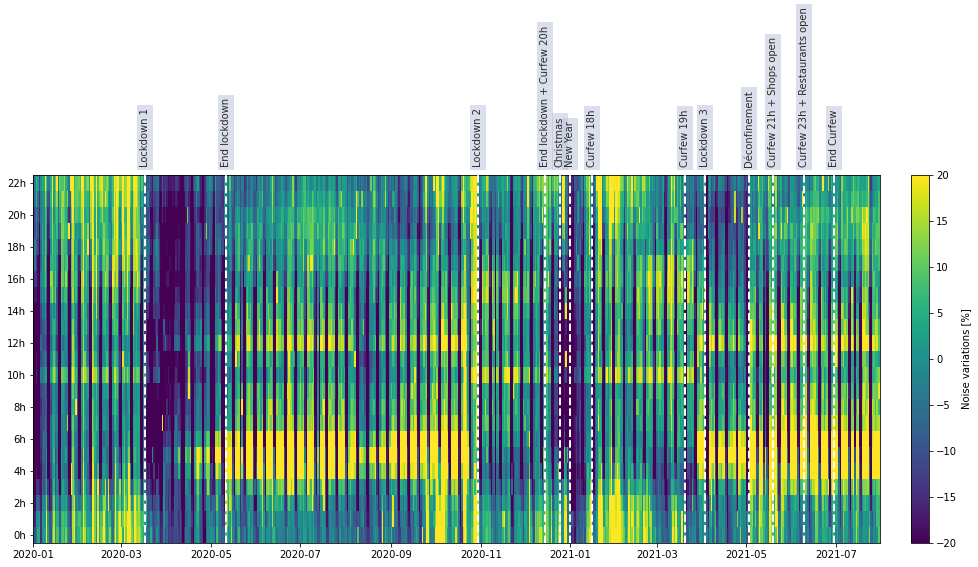

In [15]:
fig, ax = plt.subplots(figsize=(15, 8))

plt.pcolormesh(dates, h_mid, h_matrix)

box_txt = dict(boxstyle="square",
               facecolor='#B7C0D8',
               edgecolor='none',
               alpha=0.5)

for n in range(len(dates_tags)):
    t_search = dates_tags[n]
    desc_search = desc_tags[n]
    t_text = t_search - pd.Timedelta("0 days")
    plt.axvline(t_search, ls="--", lw=2, color="white", zorder=10)   # Confinement 1
    plt.text(t_text, 23.5, desc_search,
            color="#2B2B2B", fontsize="medium", rotation=90,
            ha="center", va="bottom",
            bbox=box_txt)   # Confinement 1
    
h_label = ["0h","2h","4h","6h","8h","10h","12h","14h","16h","18h","20h","22h"]
plt.yticks(np.arange(0.5, 24, 2), h_label)
plt.clim(-20, 20)
plt.colorbar(orientation="vertical", label='Noise variations [%]', pad=0.03)
plt.tight_layout()
plt.savefig('RESULTS/FR_2020/hour_{}Hz/noise_all_hours.png'.format(freq), dpi=150)